In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import keras
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import datasets, layers, models
from keras.models import Sequential
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import io
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, auc, accuracy_score, roc_curve

In [7]:
pwd 

'c:\\Users\\User\\Desktop\\emotion'

In [2]:
batch_size = 64
img_height = 140
img_width = 140

In [3]:
train_ds_1 = tf.keras.utils.image_dataset_from_directory(
    'c:\\Users\\User\\Desktop\\emotion\\dataset\\train',
    subset ="training",
    validation_split = 0.2,
    seed = 123,
    batch_size = batch_size,
    image_size =(img_height, img_width)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [6]:
train_ds_2 = tf.keras.utils.image_dataset_from_directory(
    'c:\\Users\\User\\Desktop\\emotion\\dataset\\test',
    subset = "training",
    seed = 123,
    validation_split = 0.2,
    batch_size = batch_size,
    image_size = (img_height, img_width)
)

Found 7178 files belonging to 7 classes.
Using 5743 files for training.


In [7]:
total_ds = train_ds_1.concatenate(train_ds_2)

In [4]:
val_ds_1 = tf.keras.utils.image_dataset_from_directory(
    'c:\\Users\\User\\Desktop\\emotion\\dataset\\train',
    seed =123,
    subset = "validation",
    validation_split = 0.2,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [9]:
val_ds_2 = tf.keras.utils.image_dataset_from_directory(
    'c:\\Users\\User\\Desktop\\emotion\\dataset\\test',
    seed =123,
    subset = "validation",
    validation_split = 0.2,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 7178 files belonging to 7 classes.
Using 1435 files for validation.


In [10]:
full_val_ds= val_ds_1.concatenate(val_ds_2)

In [5]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_ds_1 =train_ds_1.map(
#    lambda x, y:(normalization_layer(x),y))

train_ds_1 = train_ds_1.map(lambda x, y:(preprocess_input(tf.cast(x, tf.float32)), y))
val_ds_1 = val_ds_1.map(lambda x, y:(preprocess_input(tf.cast(x, tf.float32)), y))
AUTOTUNE = tf.data.AUTOTUNE
train_ds_1 = train_ds_1.cache().prefetch(buffer_size = AUTOTUNE)
val_ds_1 = val_ds_1.cache().prefetch(buffer_size = AUTOTUNE)

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
total_ds = total_ds.map(
    lambda x, y:(normalization_layer(x),y)
)
AUTOTUNE = tf.data.AUTOTUNE
total_ds = total_ds.cache().prefetch(buffer_size = AUTOTUNE)
full_val_ds = full_val_ds.cache().prefetch(buffer_size = AUTOTUNE)

NameError: name 'total_ds' is not defined

ResNet-18 model

In [6]:
base_model = keras.applications.ResNet50(
    weights = 'imagenet',
    input_shape=(140, 140, 3),
    include_top= False)
 # this doesn't include the Image classifier at the top

base_model.trainable = False #this freezes the base model.

inputs = keras.Input(shape=(140, 140, 3))

x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D() (x)
#x = keras.layers.Dense(256, activation='relu') (x)
outputs = keras.layers.Dense(7, activation="softmax") (x)
model = keras.Model(inputs, outputs)


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_ds_1, validation_data=val_ds_1, epochs = 10)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.4315 - loss: 1.5144 - val_accuracy: 0.4950 - val_loss: 1.3440
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.5061 - loss: 1.3187 - val_accuracy: 0.5133 - val_loss: 1.2933
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.5333 - loss: 1.2516 - val_accuracy: 0.5246 - val_loss: 1.2713
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 3222s 9s/step - accuracy: 0.5499 - loss: 1.2075 - val_accuracy: 0.5299 - val_loss: 1.2604
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1179s 3s/step - accuracy: 0.5638 - loss: 1.1748 - val_accuracy: 0.5302 - val_loss: 1.2550
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.5722 - loss: 1.1490 - val_accuracy: 0.5314 - val_loss: 1.2528
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.5792 - loss: 1.1278 - val_accuracy: 0.5320 - val_loss: 1.2526
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 18689s 52s/step - accuracy: 0.5850 - loss: 1.1099 - val

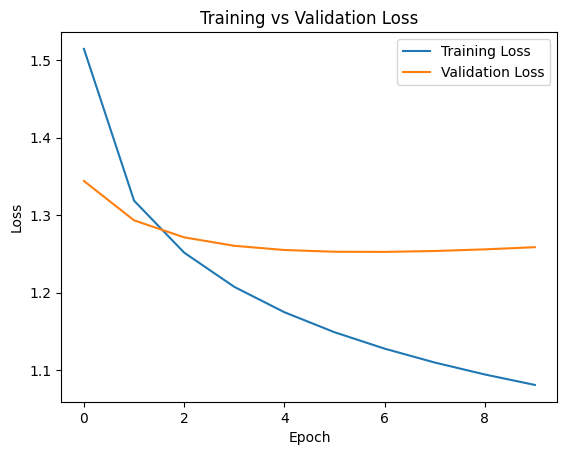

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

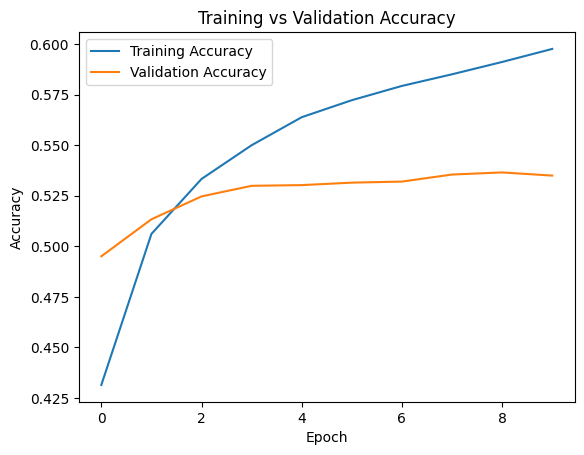

In [11]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [55]:
def residual_block(x, filters, strides =1):
    
    shortcut = x
    #first layer
    x = layers.Conv2D(filters, kernel_size =3, strides = strides, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU()(x)

    #second layer
    x = layers.Conv2D(filters, kernel_size =3, padding='same') (x)
    x = layers.BatchNormalization() (x)

    #adjusting the shortcut if shape changes
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides = strides, padding = 'same') (shortcut)
        shortcut = layers.BatchNormalization() (shortcut)
    
    #skip connections
    x = layers.Add()([x, shortcut])
    x = layers.ReLU() (x)

    return x


Each bottleneck layer will have 3 convolutional layers.

In [9]:
def bottleneck_block(x, filters, stride =1):
    shortcut = x
    #1st layer
    x = layers.Conv2D(filters,1, strides= 1, padding ='same') (x)
    x = layers.BatchNormalization() (x)
    x= layers.ReLU()(x)
    #2nd layer
    x = layers.Conv2D(filters,3,strides= stride, padding ='same') (x)
    x = layers.BatchNormalization() (x)
    x= layers.ReLU()(x)
    #3rd layer
    x = layers.Conv2D(filters * 4, 1,strides= 1, padding ='same') (x)
    x = layers.BatchNormalization() (x)

    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides= stride, padding ='same') (shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x= layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x
    

In [10]:
def resnet_50(input_shape=(140, 140, 3), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # Initial layers
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x (3 blocks)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)

    # Conv3_x (4 blocks)
    x = bottleneck_block(x, 128, stride=2)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)

    # Conv4_x (6 blocks)
    x = bottleneck_block(x, 256, stride=2)
    for _ in range(5):
        x = bottleneck_block(x, 256)

    # Conv5_x (3 blocks)
    x = bottleneck_block(x, 512, stride=2)
    x = bottleneck_block(x, 512)
    x = bottleneck_block(x, 512)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [11]:
model = resnet_50(input_shape=(140, 140, 3), num_classes=7)

In [ ]:
    #x = layers.Flatten() (x)
    #x = layers.Dense(1024, activation='relu') (x)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
history = model.fit(train_ds_1, validation_data=val_ds_1, epochs = 5)

Epoch 1/5
124/359 ━━━━━━━━━━━━━━━━━━━━ 8:40:13 133s/step - accuracy: 0.2242 - loss: 2.6646

In [1]:
history =model.fit(total_ds, validation_data=full_val_ds,epochs=20)

NameError: name 'model' is not defined